# Body Segmentation

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

In video production, for example, in weather forecasts, we often need to cut out a human image from camera and place it on top of some other footage. This is typically done using **chroma key** techniques, when a human is filmed in front of a uniform color background, which is then removed. In this lab, we will train a neural network model to cut out the human silhouette.

We will be using [Segmentation Full Body MADS Dataset](https://www.kaggle.com/datasets/tapakah68/segmentation-full-body-mads-dataset) from Kaggle. Download the dataset manually from Kaggle and unzip in into current directory.

In [33]:
dataset_path = 'segmentation_full_body_mads_dataset_1192_img'

import os
import matplotlib.pyplot as plt
import zipfile
import shutil
from typing import Optional, Callable


if not os.path.exists(dataset_path):
    with zipfile.ZipFile('mads_ds_1192.zip') as file:
        file.extractall()
    for dir in os.listdir(os.path.join(dataset_path,dataset_path)):
        shutil.move(os.path.join(dataset_path, dataset_path, dir),
                    os.path.join(dataset_path, dir))
    shutil.rmtree(os.path.join(dataset_path, dataset_path))
    

Let's see how images in the dataset look like:

In [34]:
imgs_path = os.path.join(dataset_path,'images')
masks_path = os.path.join(dataset_path,'masks')

fnames = os.listdir(imgs_path)

def load_image(img_name:str)->tuple:
    img = plt.imread(os.path.join(imgs_path,img_name))
    mask = plt.imread(os.path.join(masks_path,img_name))
    return img,mask

(-0.5, 511.5, 383.5, -0.5)

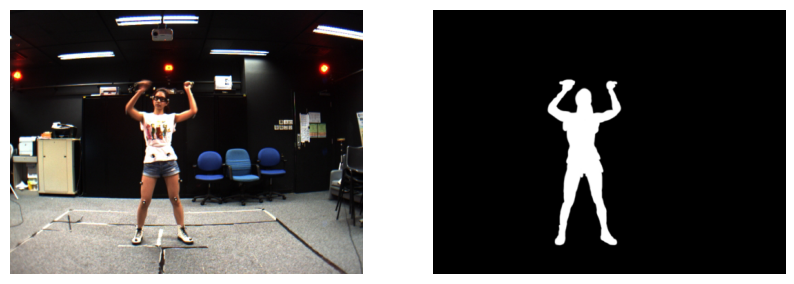

In [35]:
img, mask = load_image(fnames[5])

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[0].axis('off')
ax[1].axis('off')

In [36]:
import torch
from torch import nn
from torchvision.utils import save_image
from torch.utils.data import random_split
import torchvision
import torch.optim as optim
from torchvision.transforms import v2 as T
from torchvision import tv_tensors
from torchvision.io import ImageReadMode
from torch.utils.data import DataLoader, Dataset
from PIL import Image


def draw_pred_segmentation_masks(model: Callable, img: torch.Tensor, img_name: str)->None:
    #TODO: output both the predicted mask and the mask over the image
    model.eval()
    pred = model(img)
    img = img.reshape(img.size()[1:]).to(torch.uint8)

    #pred = pred.reshape(pred.size()[2:]).bool()
    pred[pred>0.5]=255.0
    pred[pred <= 0.5]=0.0
    #img = torchvision.utils.draw_segmentation_masks(img, pred)
    #img = torchvision.transforms.ToPILImage()(img)
    fn = img_name+'_pred.png'
    fp = os.path.join('output_imgs', fn)
    if not os.path.exists('output_imgs'):
        os.mkdir('output_imgs')
    #img.save(fp)
    save_image(pred,fp)
    return None


class MADSDataset(Dataset):
    def __init__(self, root: str, transforms: Optional[Callable]=None) -> None:
        super().__init__()
        self.root = root
        self.transforms = transforms
        self.imgs_dir = os.path.join(root,'images')
        self.masks_dir = os.path.join(root,'masks')
        self.img_names = [img_name[:-4] for img_name in os.listdir(self.imgs_dir) 
                          if os.path.isfile(os.path.join(self.imgs_dir,img_name))]

    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_fn = img_name+'.png'
        img_path = os.path.join(self.imgs_dir,img_fn)
        img = Image.open(img_path).convert('RGB')
        img = T.functional.pil_to_tensor(img)
        #img = torchvision.io.read_image(img_path, ImageReadMode.RGB)

        mask_path = os.path.join(self.masks_dir, self.img_names[idx]+'.png')
        mask = Image.open(mask_path).convert('L')
        mask = T.functional.pil_to_tensor(mask)
        mask = mask/255.0   #Since we use binary cross entropy loss, values have to be in [0,1] and
                            #v2 transforms don't scale masks, therefore we have to do it by hand
        #mask = torchvision.io.read_image(mask_path, ImageReadMode.GRAY)
        target = tv_tensors.Mask(mask)

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target, img_name

    def get_class_index(self, mask):
        mask = torch.where(mask>128,torch.ones(mask.size(), dtype=torch.float32),torch.zeros(mask.size(),dtype=torch.float32))
        mask = tv_tensors.Mask(mask)
        return mask

In [37]:
#hyperparameters
device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')
train_size = 0.7
val_size = 0.2
test_size = 1.0-(train_size+val_size)
lr = 1e-3
weight_decay = 1e-6
w_p = torch.FloatTensor([1.0])#weight for binary cross entropy loss

transforms = T.Compose([T.Resize((256,256)),# interpolation=Image.NEAREST),
                        T.ToImage(),
                        T.ToDtype(dtype={tv_tensors.Image: torch.float32, tv_tensors.Mask: torch.float32, "others": None},
                                  scale=True)])
bs = 32
no_of_epochs = 30

full_dataset = MADSDataset(root=dataset_path,transforms=transforms)
train_set, val_set, test_set = random_split(full_dataset,[train_size,val_size,test_size])
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_set, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

In [38]:
import time
from statistics import mean

def train_epoch(model, dataloader, optimizer, loss_fn, report_freq, device):
    epoch_loss=[]
    running_loss = 0.0
    starttime = time.time()
    for j, (images, targets, _) in enumerate(dataloader):
            images = images.to(device)
            targets = targets.to(device)
            optimizer.zero_grad(set_to_none=True)
            pred = model(images)
            batch_loss = loss_fn(pred, targets)
            batch_loss.backward()
            optimizer.step()
            epoch_loss.append(batch_loss.item())
            running_loss+=batch_loss.item()
            if j%report_freq==report_freq-1:
                print(f"Batch {j+1} finished, "
                      f"time = {int((time.time()-starttime)/60)} minutes {round((time.time()-starttime)%60,2)} seconds, "
                      f"loss: {running_loss/report_freq}")
                starttime = time.time()
                running_loss = 0.0
    return epoch_loss

def train_model(model,train_loader, val_loader, optimizer,no_of_epochs, report_freq, 
                device='cpu', loss_fn = nn.BCEWithLogitsLoss()):
    train_loss = []
    val_loss = []
    for epoch in range(no_of_epochs):
        epoch_starttime = time.time()
        print(f"START TRAINING FOR EPOCH {epoch + 1}:")
        model.train(True)
        epoch_loss = train_epoch(model, train_loader, optimizer, loss_fn, report_freq, device)
        train_loss+=epoch_loss
            
        running_vloss = 0.0
        model.eval()
        print(f"Training for epoch {epoch+1} done, time = "
              f"{int((time.time()-epoch_starttime)/60)} minutes {round((time.time()-epoch_starttime)%60,2)} seconds")
        with torch.no_grad():
            vbatch_starttime = time.time()

            for i, (vimages, vtargets, _) in enumerate(val_loader):
                  vimages = vimages.to(device)
                  vtargets = vtargets.to(device)
                  pred = model(vimages)
                  vloss = loss_fn(pred, vtargets)
                  val_loss.append(vloss.item())
                  running_vloss+=vloss.item()
                  #print(f"Completed validation for batch {i+1}, time = "
                  #      f"{int((time.time()-vbatch_starttime)/60)} minutes {round((time.time()-vbatch_starttime)%60,2)}"
                  #      f"seconds")
        

        val_loss.append(running_vloss/(i+1))
        train_loss+=epoch_loss
        print(f"Validation for epoch {epoch+1} done, time = "
              f"{int((time.time()-epoch_starttime)/60)} minutes {round((time.time()-epoch_starttime)%60,2)} seconds, "
              f"LOSS train {epoch_loss[-1]}, val: {val_loss[-1]}")

        
    return train_loss, val_loss


def test_model(model, test_loader, save_freq=100, device='cpu', loss_fn = nn.BCEWithLogitsLoss()):
      #TODO: Right now nothing is done with pixel accuracy. What about other metrics?
      test_loss = []
      pixel_acc = []
      model.eval()
      with torch.no_grad():
            for i, (img, mask, fn) in enumerate(test_loader):
                  img = img.to(device)
                  mask = mask.to(device)

                  pred = model(img)
                  tloss = loss_fn(pred, mask)
                  test_loss.append(tloss.item())

                  pred = torch.where(pred >=0.5, torch.ones(
                      pred.size(), dtype=torch.float32), torch.zeros(pred.size(), dtype=torch.float32))
                  correct = (pred==mask).type(dtype=torch.float32)
                  pixel_acc.append(torch.sum(correct/torch.numel(correct)).item())
                  if (i+1)%save_freq == 0:
                        draw_pred_segmentation_masks(model, img, fn[0])
      return mean(test_loss)

In [39]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Conv2d(
            in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1)
        self.act0 = nn.ReLU()
        self.bn0 = nn.BatchNorm2d(16)
        self.pool0 = nn.MaxPool2d(kernel_size=(2, 2))

        self.enc_conv1 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.enc_conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.enc_conv3 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        self.bottleneck_conv = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1)

        self.upsample0 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Conv2d(
            in_channels=384, out_channels=128, kernel_size=(3, 3), padding=1)
        self.dec_act0 = nn.ReLU()
        self.dec_bn0 = nn.BatchNorm2d(128)

        self.upsample1 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv1 = nn.Conv2d(
            in_channels=192, out_channels=64, kernel_size=(3, 3), padding=1)
        self.dec_act1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv2 = nn.Conv2d(
            in_channels=96, out_channels=32, kernel_size=(3, 3), padding=1)
        self.dec_act2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv3 = nn.Conv2d(
            in_channels=48, out_channels=1, kernel_size=(1, 1))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))
        e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))
        e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))
        e3 = self.pool3(self.bn3(self.act3(self.enc_conv3(e2))))

        cat0 = self.bn0(self.act0(self.enc_conv0(x)))
        cat1 = self.bn1(self.act1(self.enc_conv1(e0)))
        cat2 = self.bn2(self.act2(self.enc_conv2(e1)))
        cat3 = self.bn3(self.act3(self.enc_conv3(e2)))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_bn0(self.dec_act0(self.dec_conv0(
            torch.cat((self.upsample0(b), cat3), dim=1))))
        d1 = self.dec_bn1(self.dec_act1(self.dec_conv1(
            torch.cat((self.upsample1(d0), cat2), dim=1))))
        d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(
            torch.cat((self.upsample2(d1), cat1), dim=1))))
        d3 = self.sigmoid(self.dec_conv3(
            torch.cat((self.upsample3(d2), cat0), dim=1)))
        return d3

In [40]:
model = UNet()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)#TODO: Define learning rate and weight decay
loss_fn = nn.BCEWithLogitsLoss(pos_weight=w_p)

train_loss, val_loss = train_model(model=model, train_loader=train_loader, val_loader=val_loader,
                                   optimizer=optimizer, no_of_epochs=no_of_epochs, report_freq=5, device=device,
                                   loss_fn=loss_fn)
print("TRAINING FINISHED") 

savetime = time.strftime('%Y-%m-%d-%H%%%M', time.localtime()).replace('-', '_')
model_fn = 'BodySegmentation_model_'+savetime+'.pth'
if not os.path.exists('models'):
    os.mkdir('models')

model_fp = 'models/'+model_fn
torch.save(model, model_fp)

START TRAINING FOR EPOCH 1:


/usr/local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Batch 5 finished, time = 1 minutes 18.82 seconds, loss: 0.9383011341094971
Batch 10 finished, time = 1 minutes 23.14 seconds, loss: 0.9048946022987365
Batch 15 finished, time = 1 minutes 11.37 seconds, loss: 0.8908086538314819
Batch 20 finished, time = 1 minutes 31.37 seconds, loss: 0.8770749926567077
Batch 25 finished, time = 1 minutes 38.36 seconds, loss: 0.861261248588562
Training for epoch 1 done, time = 7 minutes 21.49 seconds
Validation for epoch 1 done, time = 8 minutes 6.21 seconds, LOSS train 0.8647440075874329, val: 0.8022003844380379
START TRAINING FOR EPOCH 2:
Batch 5 finished, time = 1 minutes 24.78 seconds, loss: 0.8427378177642822
Batch 10 finished, time = 1 minutes 20.95 seconds, loss: 0.830208957195282
Batch 15 finished, time = 1 minutes 25.51 seconds, loss: 0.8224598884582519
Batch 20 finished, time = 1 minutes 20.8 seconds, loss: 0.811638081073761
Batch 25 finished, time = 1 minutes 13.32 seconds, loss: 0.8034577608108521
Training for epoch 2 done, time = 7 minutes 0

In [41]:
# model = torch.load('models/BodySegmentation_model_2023_12_31_22%31.pth')
# model.to(device)

In [42]:
test_loss = test_model(model=model, test_loader=test_loader,
                       device=device, save_freq=1)
print(f"Test loss = {test_loss}")

Test loss = 0.6818152220309281


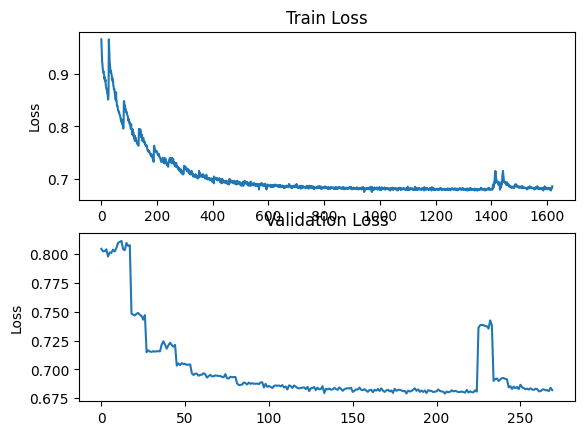

In [43]:
from matplotlib import pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(train_loss)
ax1.set_ylabel("Loss")
ax1.set_title("Train Loss")

ax2.plot(val_loss)
ax2.set_ylabel("Loss")
ax2.set_title("Validation Loss")

plt.show()

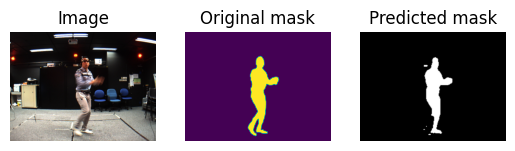

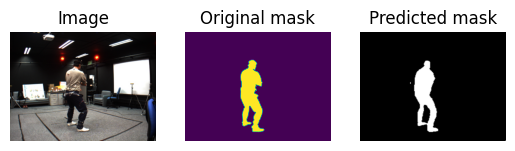

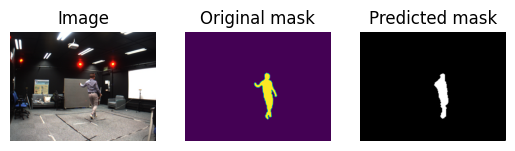

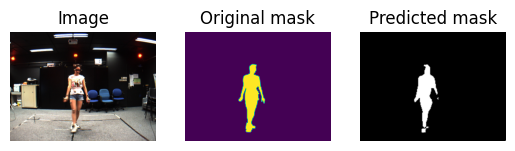

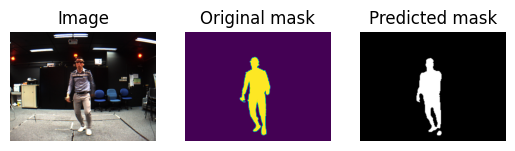

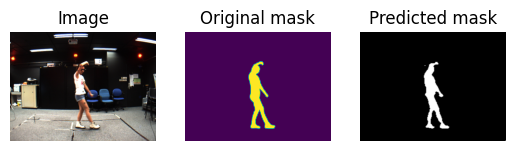

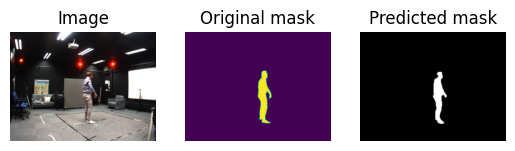

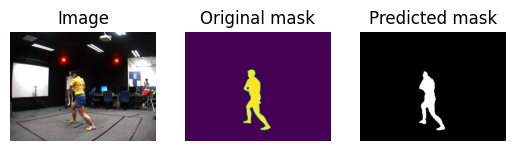

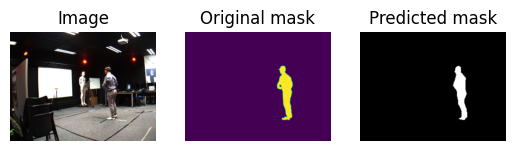

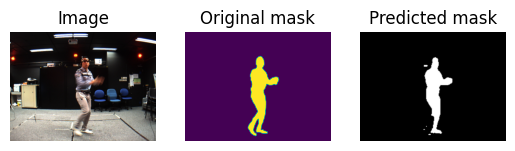

In [44]:
#TODO: Masks next to images?

import random
from IPython import display as D

output_path = 'output_imgs'
imgs_path = os.path.join(dataset_path, 'images')
masks_path = os.path.join(dataset_path,'masks')
img_names = [img_name[:-9] for img_name in os.listdir(output_path)
             if os.path.isfile(os.path.join(output_path, img_name))]
#output_img_names = os.listdir(output_path)
#output_imgs = [os.path.join(output_path, img_name)
#               for img_name in output_img_names]
for i in range(10):
    img_name = random.choice(img_names)
    img = Image.open(os.path.join(imgs_path,img_name+'.png')).convert('RGB')
    mask = Image.open(os.path.join(masks_path, img_name+'.png')).convert('L')
    output_img = Image.open(os.path.join(output_path, img_name+'_pred.png')).resize((512,384))
    fig, (ax1,ax2,ax3) = plt.subplots(1,3)
    ax1.set_title('Image')
    ax1.axis('off')
    ax1.imshow(img)
    ax2.set_title('Original mask')
    ax2.axis('off')
    ax2.imshow(mask)
    ax3.set_title('Predicted mask')
    ax3.axis('off')
    ax3.imshow(output_img)
    plt.show()
    #D.display(D.Image(filename=img))